# Zillow’s Home Value Prediction (Zestimate)

Zillow라는 미국 부동산 회사에서 Kaggle을 통해 제안한 과제는 미래 가격을 예측하는 것이지만, 이 데이터를 기반으로 주택가격결정모형을 회귀분석을 활용하여 구해보고자 한다.

데이터셋은 [Kaggle](https://www.kaggle.com/c/zillow-prize-1 "Zillow Prize: Zillow’s Home Value Prediction (Zestimate)")을 통해서 제공을 하고 있으며, 현재 상금도 걸려있는 과제이기도 하다.
지금은 2016년도 자료만 제공되고 있으며, 추후 2017년 10월에 2017년도 데이터가 추가될 예정. 
이번에는 현재 제공되고 있는 2016년도 데이터를 바탕으로 분석을 진행할 것임.


제공되는 데이터 형태는 다음과 같다.
* properties_2016.csv (618 MB)
* sample_submission.csv (59.7 MB)
* train_2016_v2.csv (2.33 MB)
* zillow_data_dictionary.xlsx (20.1 KB)

(부가적인 설명 추가예정)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

%matplotlib inline
pd.options.display.max_columns = 60

## 데이터  로드

주택에 대한 정보(58가지 변수)가 포함되어 있는 'properties_2016.csv'파일을 로드한다.

In [2]:
prop = pd.read_csv('property.csv')

/Users/sinsanghun/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
prop.shape

(2985217, 58)

## 데이터 상태 확인

### missing value 탐색 

In [4]:
# missing pct 그래프 출력 및 마지막 row에 missing pct 추가해서 리턴 
def missing(df):
    missing_pct = df.isnull().sum() / df.isnull().count()
    df.loc["missing_pct"] = missing_pct.round(3)
    missing_pct = missing_pct.sort_values(ascending=False)
    plt.figure(figsize=(12,18), dpi=200)
    sns.barplot(y=missing_pct.index, x=missing_pct.values, alpha=0.9, color="red")
    plt.xlabel("Missing_pct", fontsize=12)
    plt.title("Percent of missing values in each column", fontsize=15)
    return df

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147.0,NaN,NaN,NaN,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.000,NaN,NaN,NaN,NaN,NaN,NaN,3.414444e+07,-1.186541e+08,85768.000,NaN,NaN,NaN,NaN,NaN,010D,269.000,NaN,6.037800e+07,37688.000,3101.000,NaN,96337.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.000,2015.000,9.000,NaN,NaN,NaN,NaN
1,10759547.0,NaN,NaN,NaN,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.000,NaN,NaN,NaN,NaN,NaN,NaN,3.414043e+07,-1.186254e+08,4083.000,NaN,NaN,NaN,NaN,NaN,0109,261.000,LCA11*,6.037800e+07,37688.000,3101.000,NaN,96337.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27516.000,2015.000,27516.000,NaN,NaN,NaN,NaN
2,10843547.0,NaN,NaN,NaN,0.000,0.000,NaN,NaN,NaN,NaN,NaN,73026.000,NaN,NaN,73026.000,NaN,NaN,6037.000,NaN,NaN,NaN,NaN,NaN,NaN,3.398936e+07,-1.183946e+08,63085.000,NaN,NaN,NaN,NaN,NaN,1200,47.000,LAC2,6.037703e+07,51617.000,3101.000,NaN,96095.000,0.000,NaN,NaN,NaN,2.000,NaN,NaN,NaN,NaN,NaN,650756.000,1413387.000,2015.000,762631.000,20800.37,NaN,NaN,NaN
3,10859147.0,NaN,NaN,NaN,0.000,0.000,3.000,7.000,NaN,NaN,NaN,5068.000,NaN,NaN,5068.000,NaN,NaN,6037.000,NaN,NaN,NaN,NaN,NaN,NaN,3.414886e+07,-1.184372e+08,7521.000,NaN,NaN,NaN,NaN,NaN,1200,47.000,LAC2,6.037141e+07,12447.000,3101.000,27080.000,96424.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,1948.00,1.000,NaN,571346.000,1156834.000,2015.000,585488.000,14557.57,NaN,NaN,NaN
4,10879947.0,NaN,NaN,NaN,0.000,0.000,4.000,NaN,NaN,NaN,NaN,1776.000,NaN,NaN,1776.000,NaN,NaN,6037.000,NaN,NaN,NaN,NaN,NaN,NaN,3.419417e+07,-1.183858e+08,8512.000,NaN,NaN,NaN,NaN,NaN,1210,31.000,LAM1,6.037123e+07,12447.000,3101.000,46795.000,96450.000,0.000,NaN,NaN,NaN,1.000,NaN,NaN,1947.00,NaN,NaN,193796.000,433491.000,2015.000,239695.000,5725.17,NaN,NaN,NaN
5,10898347.0,NaN,NaN,NaN,0.000,0.000,4.000,7.000,NaN,NaN,NaN,2400.000,NaN,NaN,2400.000,NaN,NaN,6037.000,NaN,NaN,NaN,NaN,NaN,NaN,3.417187e+07,-1.183809e+08,2500.000,NaN,NaN,NaN,NaN,NaN,1210,31.000,LAC4,6.037125e+07,12447.000,3101.000,46795.000,96446.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,1943.00,1.000,NaN,176383.000,283315.000,2015.000,106932.000,3661.28,NaN,NaN,NaN
6,10933547.0,NaN,NaN,NaN,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.000,NaN,NaN,NaN,NaN,NaN,NaN,3.413193e+07,-1.183515e+08,NaN,NaN,NaN,NaN,NaN,NaN,010V,260.000,LAC2,6.037144e+07,12447.000,3101.000,274049.000,96049.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,397945.000,554573.000,2015.000,156628.000,6773.34,NaN,NaN,NaN
7,10940747.0,NaN,NaN,NaN,0.000,0.000,NaN,NaN,NaN,NaN,NaN,3611.000,NaN,NaN,3611.000,NaN,NaN,6037.000,NaN,NaN,NaN,NaN,NaN,NaN,3.417134e+07,-1.183149e+08,5333.000,NaN,NaN,NaN,NaN,NaN,1210,31.000,BUC4YY,6.037311e+07,396054.000,3101.000,NaN,96434.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,1946.00,1.000,NaN,101998.000,688486.000,2015.000,586488.000,7857.84,NaN,NaN,NaN
8,10954547.0,NaN,NaN,NaN,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.000,NaN,NaN,NaN,NaN,NaN,NaN,3.421821e+07,-1.183313e+08,145865.000,NaN,NaN,NaN,NaN,NaN,010D,269.000,BUR1*,6.037310e+07,396054.000,3101.000,NaN,96436.000,0.000,NaN,NaN,NaN

/Users/sinsanghun/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'nanumgothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


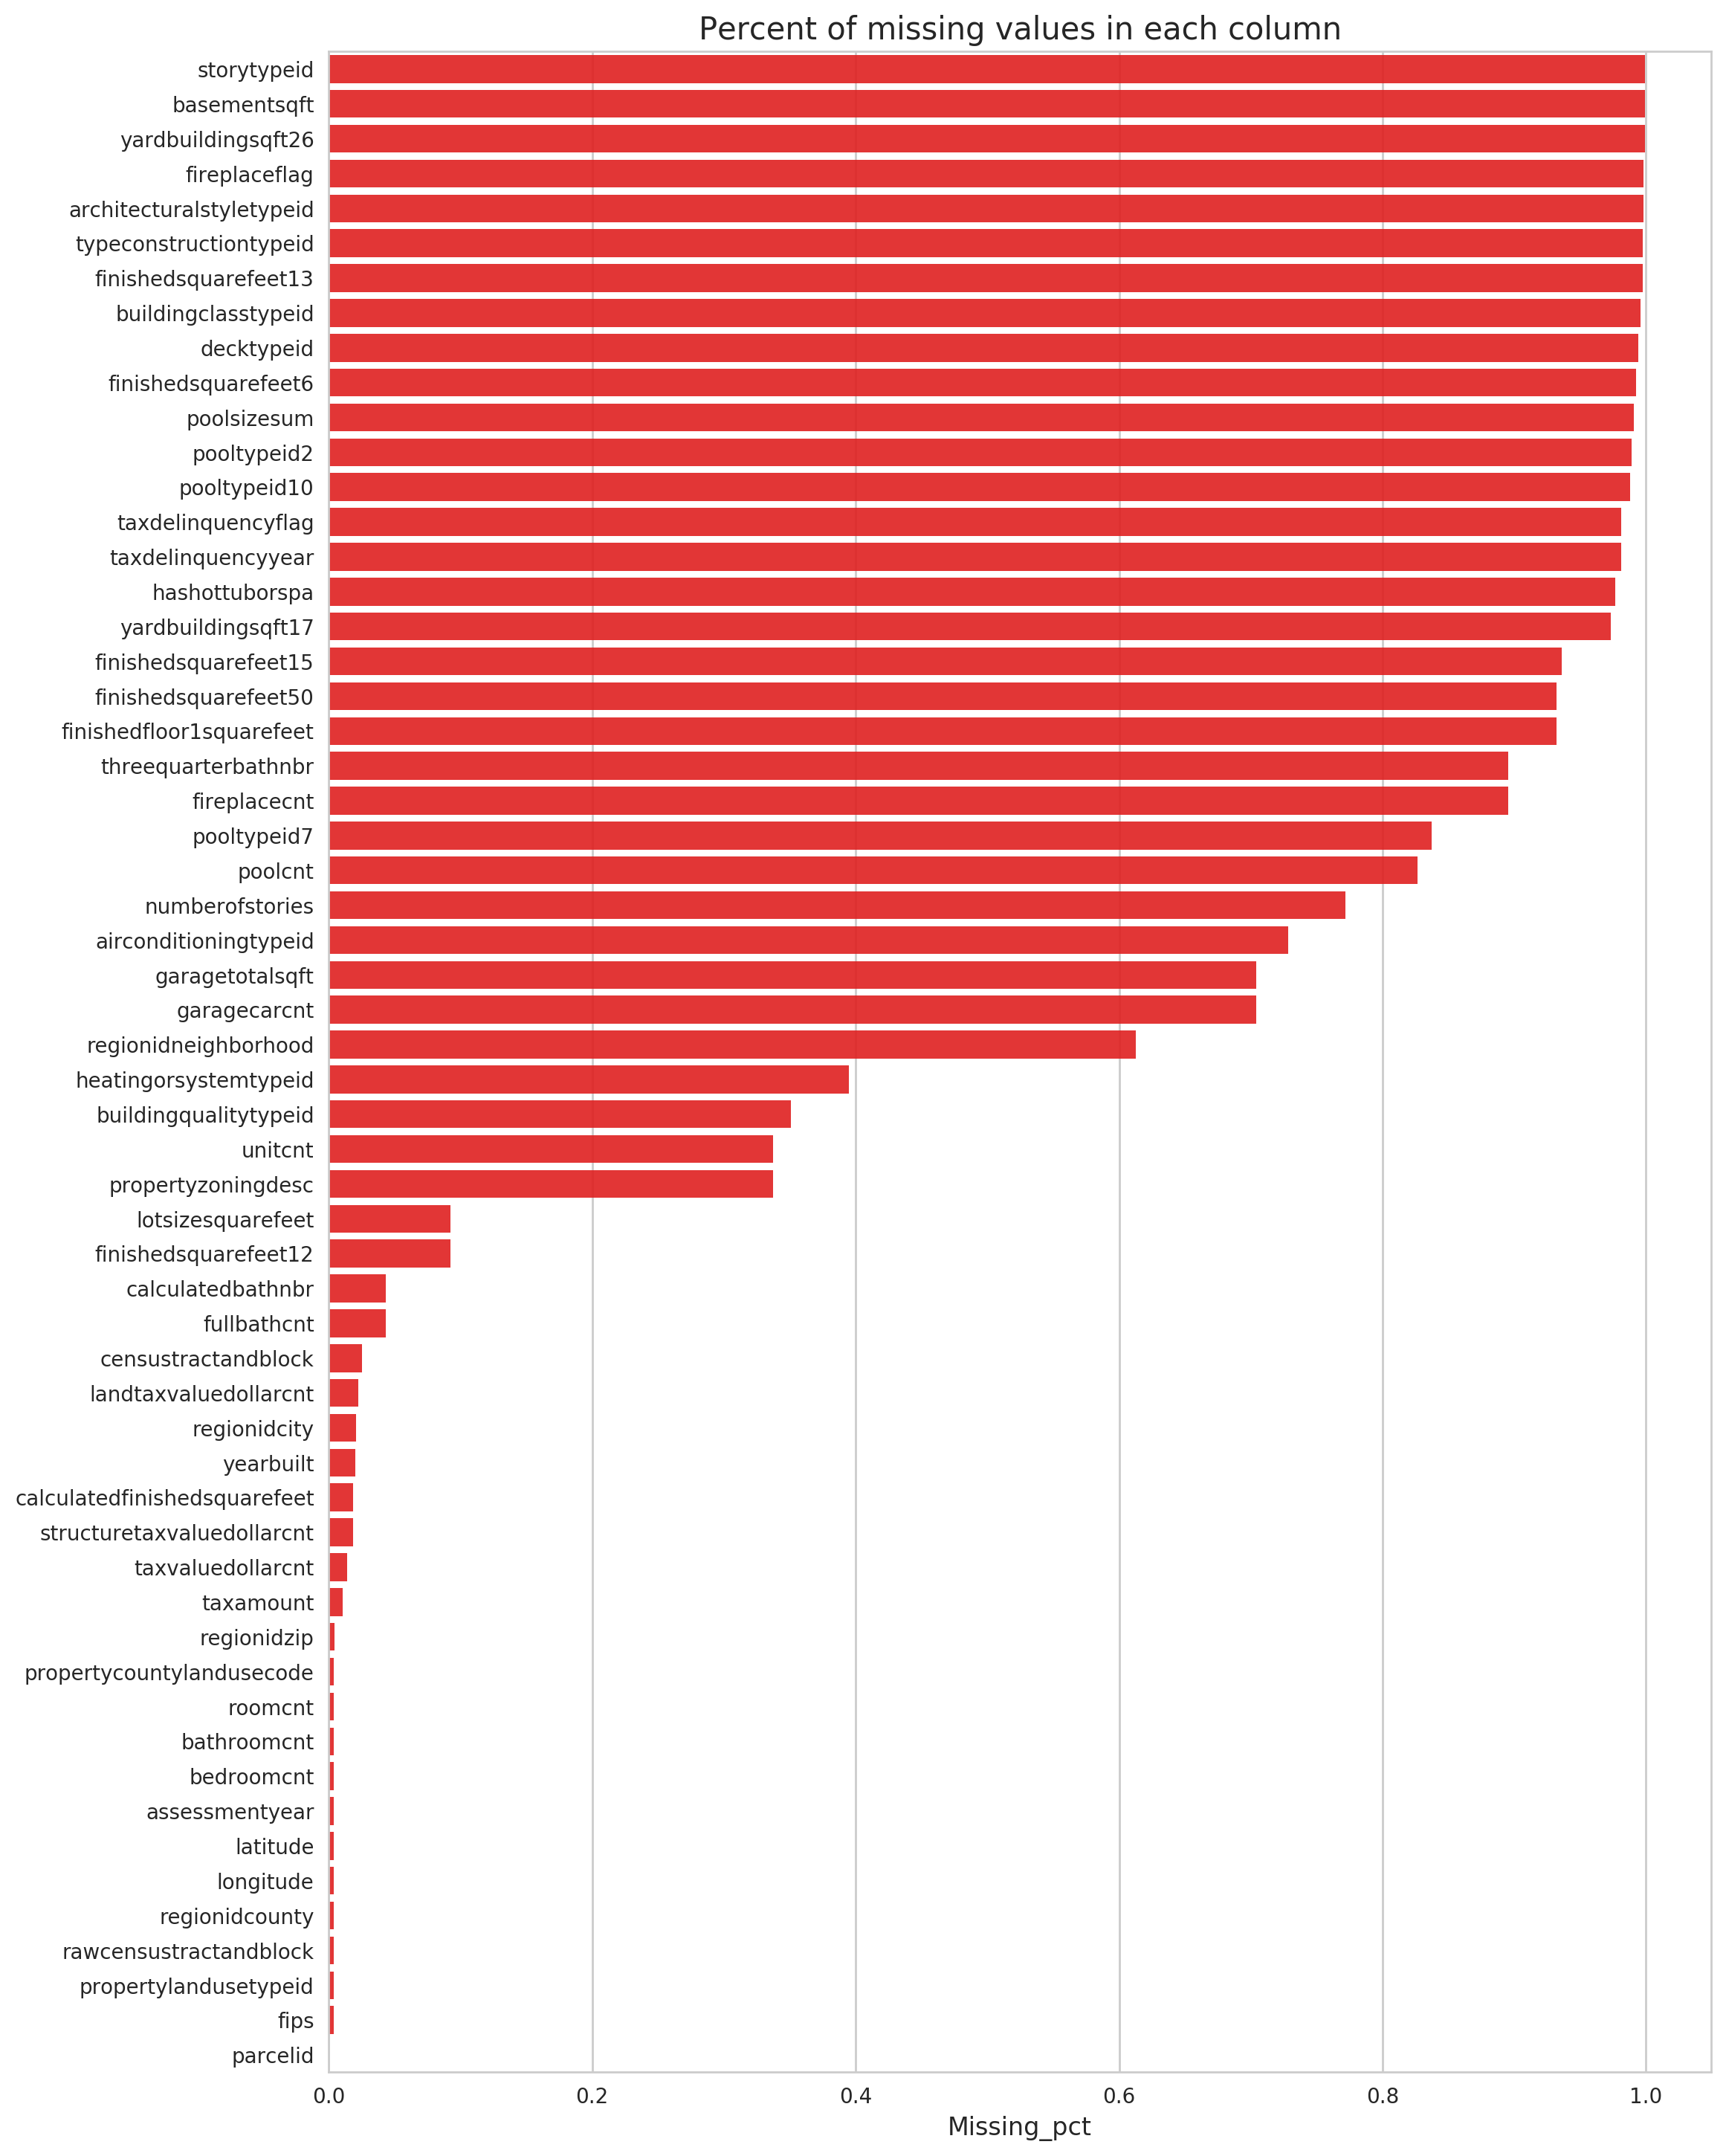

In [5]:
missing(prop)

결측치가 높은 데이터(70%이상)는 변수로서 활용이 불가능하다고 판단되어 분석에서 제외하도록 한다.  

In [6]:
# missing_pct가 70% 미만인 변수만 남긴다.
def missing70(df):
    df2 = df.loc[:,df.loc["missing_pct"] < 0.7]
    print(df2.shape)
    return df2

In [7]:
prop2 = missing70(prop)

(2985218, 30)


In [8]:
prop2[["airconditioningtypeid","hashottuborspa", "poolcnt"]]=prop[["airconditioningtypeid","hashottuborspa", "poolcnt"]]

/Users/sinsanghun/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/pandas/core/frame.py:2352: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


변수별 관계을 파악하고, 도메인 지식을 활용하여 필요없는 변수제외한 'df'를 생성해 준다.

* 추가로 삭제할 변수와 이유
 - parcelid: 건물ID
 - calculatedbathnbr: bathroomcnt과 같은 개념
 - finishedsquarefeet12 : 세분화된 면적으로 calculatedfinishedsquarefeet에 포함되어 있음
 - fullbathcnt: 세분화된 화장실 구조로 bathroomcnt에 포함되어 있음
 - propertycountylandusecode: propertylandusetypeid와 유사한 개념
 - propertyzoningdesc: propertylandusetypeid와 유사한 개념
 - rawcensustractandblock, censustractandblock: 인구조사와 관련한 ID개념, 의미없는 항목
 - fips : 하위 개념인 regionidcity을 사용할 것임
 - regionidcounty: 하위 개념인 regionidcity을 사용할 것임
 - regionidneighborhood: 상위 개념인 regionidcity을 사용할 것임
 - regionidzip: regionidcity와 같은 개념
 - roomcnt: 대부분 0으로 기입되어 있어 bedroomcnt을 사용할 것임
 - assessmentyear: 전부다 2015년임
 - taxvaluedollarcnt, landtaxvaluedollarcnt, taxamount: target이 되는 가격 변수는 structuretaxvaluedollarcnt을 사용

In [9]:
df = prop2[["airconditioningtypeid",
"bathroomcnt",
"bedroomcnt",
"buildingqualitytypeid",
"calculatedfinishedsquarefeet",
"hashottuborspa",
"heatingorsystemtypeid",
"latitude",
"longitude",
"lotsizesquarefeet",
"poolcnt",
"propertylandusetypeid",
"regionidcity",
"unitcnt",
"yearbuilt",
"structuretaxvaluedollarcnt"]]

종속변수인 structuretaxvaluedollarcnt에서 상식에 벗어나는 가격을 갖는 행은 삭제한다.

In [10]:
df = df[df["structuretaxvaluedollarcnt"]>=10000]

bathroomcnt, bedroomcnt가 0인 데이터는 기록이 잘못된 이상치로 판단하고 삭제한다.

In [11]:
df = df[df["bathroomcnt"]!=0]
df = df[df["bedroomcnt"]!=0]

남은 변수들의 결측치를 확인해본다.

In [12]:
def missingct(df):
    missing_ct = df.isnull().sum().sort_values(ascending=False)
    print(missing_ct)

In [13]:
missingct(df)

hashottuborspa                  2767871
poolcnt                         2321627
airconditioningtypeid           2031089
heatingorsystemtypeid           1045699
buildingqualitytypeid            927830
unitcnt                          905089
lotsizesquarefeet                197568
regionidcity                      46350
yearbuilt                          3765
calculatedfinishedsquarefeet        222
bathroomcnt                          18
bedroomcnt                            7
structuretaxvaluedollarcnt            0
propertylandusetypeid                 0
longitude                             0
latitude                              0
dtype: int64


airconditioningtypeid, hashottuborspa, poolcnt의 NaN은 갯수가 0인 경우에 해당하므로 NaN에 0을 채워 사용한다.

In [14]:
df[["hashottuborspa"]] = df[["hashottuborspa"]].fillna(0)
df[["poolcnt"]] = df[["poolcnt"]].fillna(0)
df[["airconditioningtypeid"]] = df[["airconditioningtypeid"]].fillna(0)
df[["heatingorsystemtypeid"]] = df[["heatingorsystemtypeid"]].fillna(0)

결측값이 하나라도 있는 데이터의 행을 삭제한다.

In [15]:
df1 = df.dropna(axis=0)

In [16]:
missingct(df1)

structuretaxvaluedollarcnt      0
yearbuilt                       0
unitcnt                         0
regionidcity                    0
propertylandusetypeid           0
poolcnt                         0
lotsizesquarefeet               0
longitude                       0
latitude                        0
heatingorsystemtypeid           0
hashottuborspa                  0
calculatedfinishedsquarefeet    0
buildingqualitytypeid           0
bedroomcnt                      0
bathroomcnt                     0
airconditioningtypeid           0
dtype: int64


In [17]:
# 인덱스정렬
a = np.arange(len(df1))
df1 = df1.set_index(a)

In [18]:
df1.head()

,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,propertylandusetypeid,regionidcity,unitcnt,yearbuilt,structuretaxvaluedollarcnt
0,1.0,2.0,4.0,4.0,3633.0,0,2.0,34560018.0,-118169806.0,9826.0,0.0,261.0,40227.0,1.0,2005.0,218982.0
1,0.0,4.0,5.0,4.0,2865.0,0,0.0,33879216.0,-118361434.0,4990.0,0.0,246.0,33612.0,2.0,1972.0,267623.0
2,1.0,2.0,2.0,4.0,1090.0,0,2.0,33974100.0,-118423000.0,40247.0,0.0,266.0,12447.0,1.0,2004.0,229399.0
3,0.0,2.0,3.0,4.0,2077.0,0,2.0,34012977.0,-118479243.0,6490.0,0.0,261.0,26964.0,1.0,1926.0,207035.0
4,0.0,2.0,4.0,7.0,1931.0,0,0.0,33990297.0,-118275168.0,5420.0,0.0,246.0,12447.0,2.0,1957.0,122915.0


칼럼이름이 너무 길기 때문에 축약하여 사용한다.

In [19]:
df1.columns = ["aircondition", "bath", "bed", "qualitytype", "cfsf", "spa", "heating", "latitude", "longitude", "lot", "pool", "landuse", "city", "unitcnt", "year", "price"]

In [20]:
df1.head()

,aircondition,bath,bed,qualitytype,cfsf,spa,heating,latitude,longitude,lot,pool,landuse,city,unitcnt,year,price
0,1.0,2.0,4.0,4.0,3633.0,0,2.0,34560018.0,-118169806.0,9826.0,0.0,261.0,40227.0,1.0,2005.0,218982.0
1,0.0,4.0,5.0,4.0,2865.0,0,0.0,33879216.0,-118361434.0,4990.0,0.0,246.0,33612.0,2.0,1972.0,267623.0
2,1.0,2.0,2.0,4.0,1090.0,0,2.0,33974100.0,-118423000.0,40247.0,0.0,266.0,12447.0,1.0,2004.0,229399.0
3,0.0,2.0,3.0,4.0,2077.0,0,2.0,34012977.0,-118479243.0,6490.0,0.0,261.0,26964.0,1.0,1926.0,207035.0
4,0.0,2.0,4.0,7.0,1931.0,0,0.0,33990297.0,-118275168.0,5420.0,0.0,246.0,12447.0,2.0,1957.0,122915.0


추후 다시 이용할 것을 대비하여 전처리한 데이터를 저장한다.

In [21]:
df1[["aircondition", "qualitytype", "spa", "heating", "pool", "landuse","city"]] = df1[["aircondition", "qualitytype", "spa", "heating", "pool", "landuse", "city"]].astype(str)

In [22]:
# correlation matrix 생성 함수
def corrmatrix(df):
    corrmat = df.corr()
    plt.subplots(figsize=(11, 9), dpi=150)
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corrmat, vmax=.8, square=True, cmap=cmap, annot=True)

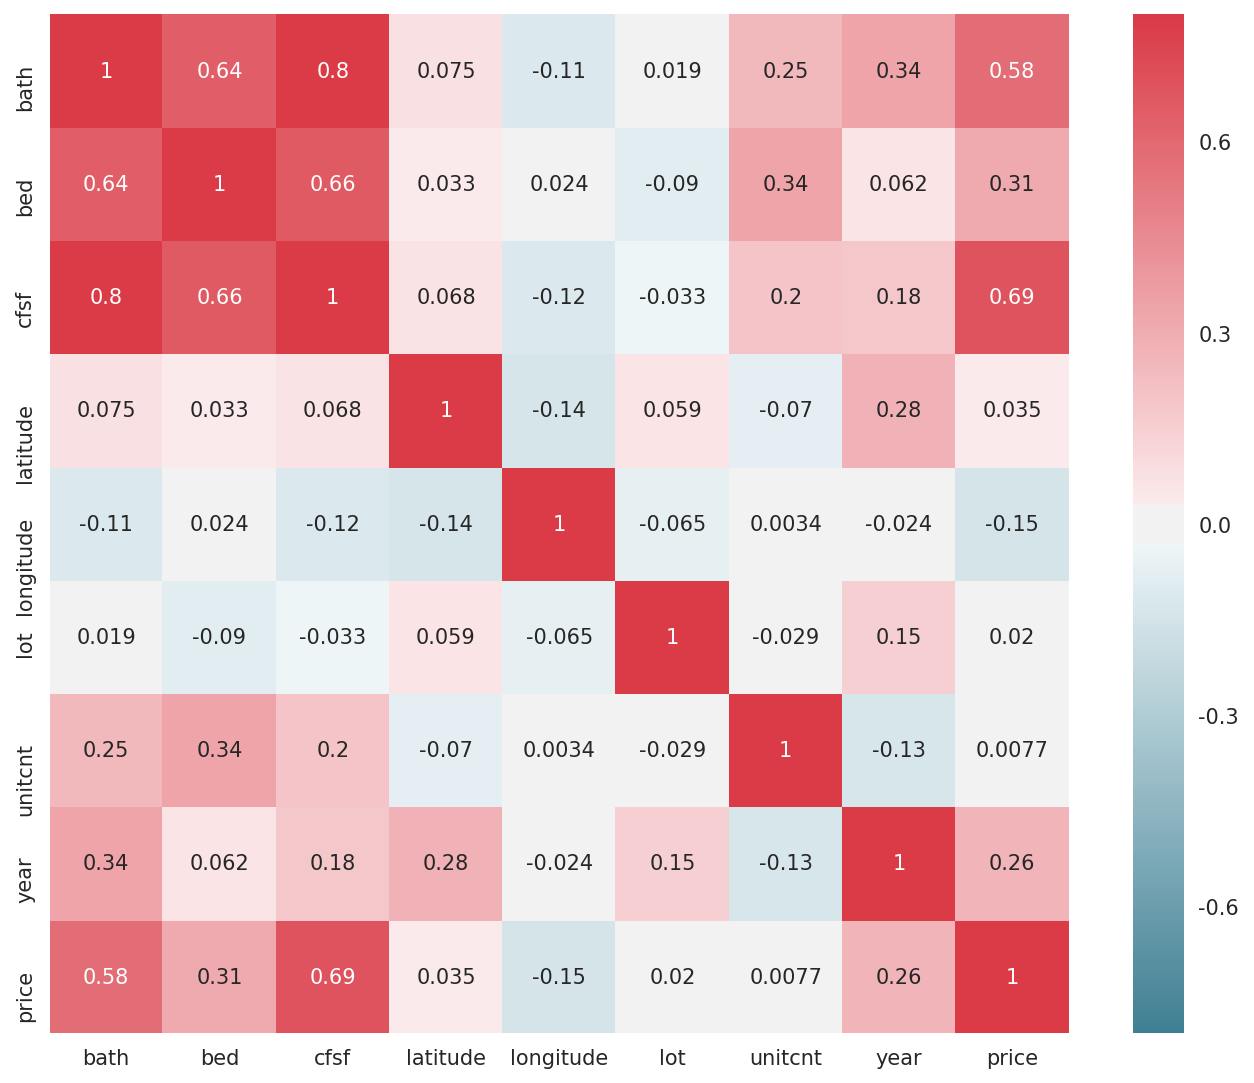

In [23]:
corrmatrix(df1)

변수들 간의 상관관계를 확인하기 위해 히트맵 생성

In [263]:
model1 = sm.OLS.from_formula('price ~ C(aircondition) + bath + bed + C(qualitytype) + cfsf + longitude + latitude + C(spa) + C(heating) + lot + C(pool) + C(landuse) + unitcnt + year', df1)
result1 = model1.fit()
print(result1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.605
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                 7.425e+04
Date:                Wed, 12 Jul 2017   Prob (F-statistic):               0.00
Time:                        12:51:49   Log-Likelihood:            -2.4076e+07
No. Observations:             1842156   AIC:                         4.815e+07
Df Residuals:                 1842117   BIC:                         4.815e+07
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept               -2

종속변수와 상관관계가 떨어지는 것으로 보이는 lot 변수를 plot_regress_exog를 이용해 분석한다.

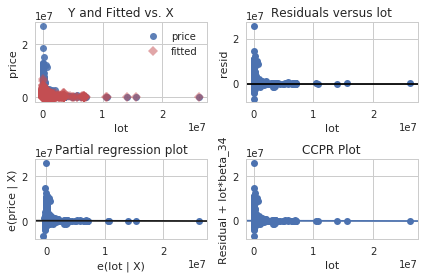

In [36]:
plt.figure(figsize=(8,8), dpi=150)
fig = sm.graphics.plot_regress_exog(result1, 'lot')
fig.suptitle("")
plt.show()

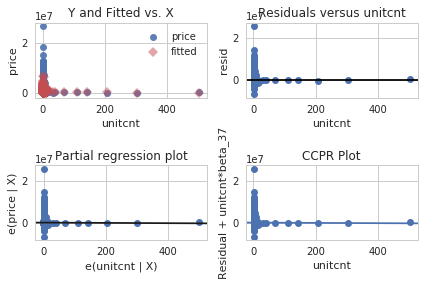

In [76]:
plt.figure(figsize=(8,8), dpi=150)
fig = sm.graphics.plot_regress_exog(result1, 'unitcnt')
fig.suptitle("")
plt.show()

partial regression plot의 기울기가 수평에 가까운 것으로 보아 lot 이 회귀분석 모델에 주는 영향은 미비한 것으로 보인다.

lot, unitcnt와 P-value가 높게 나왔던 aircondition을 제외하고 새로운 모델을 생성한다.

In [26]:
model2 = sm.OLS.from_formula('price ~ bath + bed + C(qualitytype) + cfsf + latitude +  longitude + C(spa) + C(heating) + C(pool) + C(landuse) + year', df1)
result2 = model2.fit()
print(result2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.604
Model:                            OLS   Adj. R-squared:                  0.604
Method:                 Least Squares   F-statistic:                 8.522e+04
Date:                Wed, 12 Jul 2017   Prob (F-statistic):               0.00
Time:                        16:02:30   Log-Likelihood:            -2.4078e+07
No. Observations:             1842156   AIC:                         4.816e+07
Df Residuals:                 1842122   BIC:                         4.816e+07
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               -2.3

aircondition, lot, unitcnt 변수를 제외해도 성능은 유지된다. 

## 아웃라이어 제거

모형에서 설명하고 있는 데이터와 동떨어진 값을 가지는 데이터를 **아웃라이어(outlier)**라고 한다.

회귀 분석에는 잔차의 크기가 큰 데이터가 아웃라이어가 되는데 이 중에서도 주로 관심을 가지는 것은 레버리지와 잔차의 크기가 모두 큰 데이터들이다.

잔차와 레버리지를 동시에 보기위한 기준으로는 Cook's Distance가 있다.  다음과 같이 정의되는 값으로 레버리지가 커지거나 잔차의 크기가 커지면 Cook's Distance 값이 커진다.

$$ D_i = \frac{e_i^2}{\text{RSS}}\left[\frac{h_{ii}}{(1-h_{ii})^2}\right] $$

Fox' Outlier Recommendation 은 Cook's Distance가 다음과 같은 기준값보다 클 때 아웃라이어로 판단하자는 것이다.

$$ D_i > \dfrac{4}{N − K - 1} $$

In [29]:
influence = result2.get_influence()
cooks_d2, pvals = influence.cooks_distance
fox_cr = 4 / (len(df1) - result2.df_model - 1)
idx = np.where(cooks_d2 > fox_cr)[0]

In [30]:
# 인덱스정렬
a = np.arange(len(df1))
df1 = df1.set_index(a)

In [37]:
df1.to_csv("df1.csv")

In [31]:
df1.tail()

,aircondition,bath,bed,qualitytype,cfsf,spa,heating,latitude,longitude,lot,pool,landuse,city,unitcnt,year,price
1842151,0.0,2.0,2.0,7.0,1270.0,0,7.0,33966259.0,-118297173.0,4079.0,0.0,261.0,12447.0,1.0,1936.0,62683.0
1842152,0.0,2.0,4.0,7.0,1484.0,0,2.0,34123566.0,-117826007.0,8492.0,0.0,261.0,11626.0,1.0,1955.0,55094.0
1842153,1.0,3.0,5.0,4.0,2862.0,0,2.0,34095425.0,-117740858.0,4499.0,0.0,269.0,20008.0,1.0,2012.0,304646.0
1842154,0.0,2.0,4.0,4.0,2360.0,0,20.0,34689046.0,-118066841.0,7531.0,0.0,261.0,5534.0,1.0,2013.0,201752.0
1842155,0.0,1.0,2.0,7.0,798.0,0,0.0,34769356.0,-118553521.0,7034153.0,0.0,263.0,5534.0,1.0,2006.0,49749.0


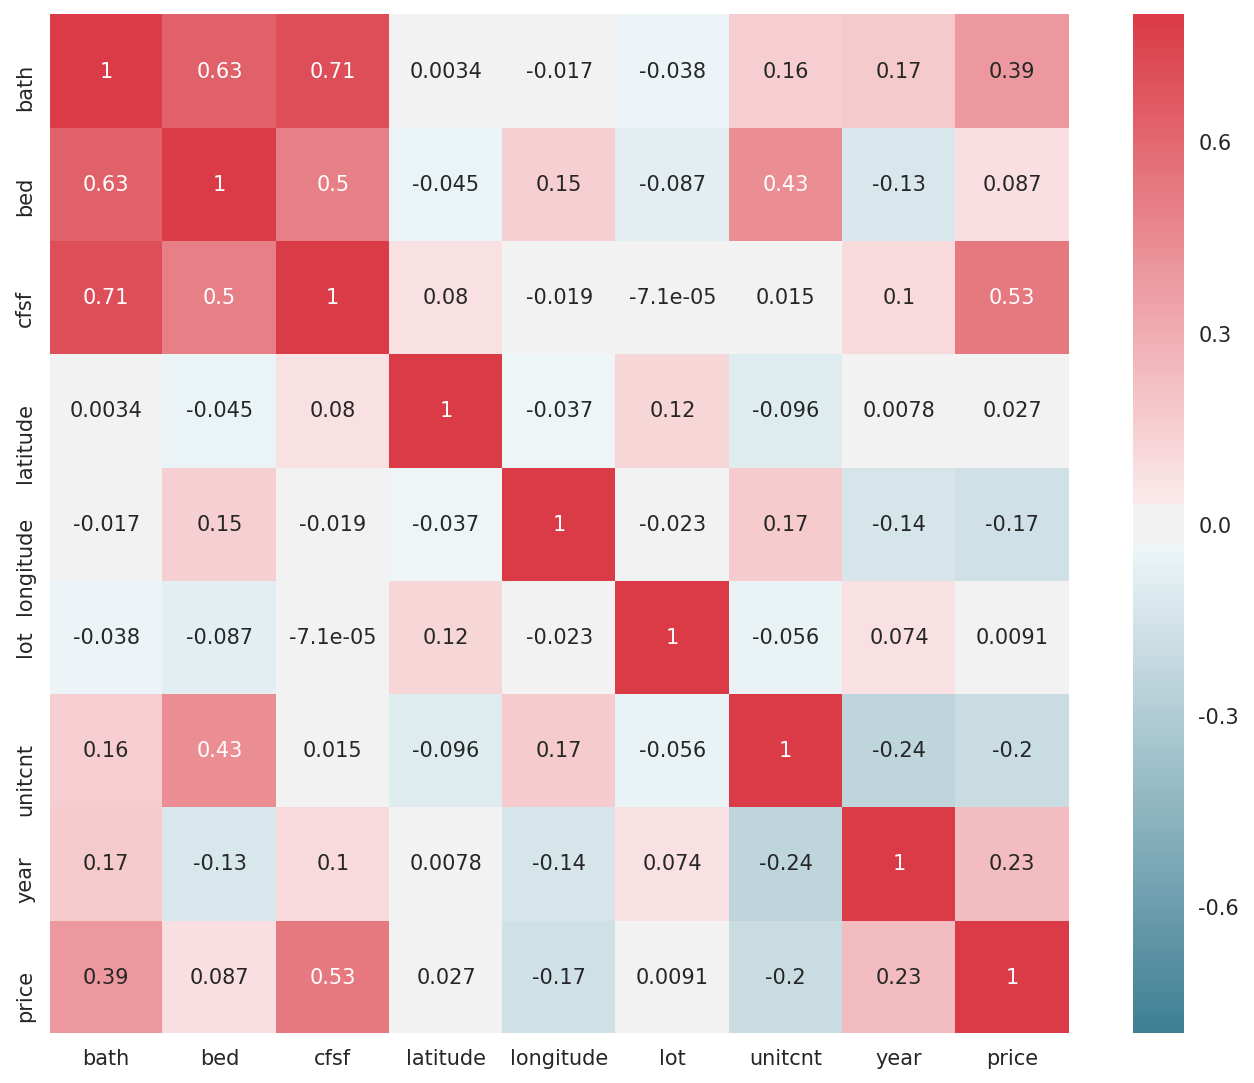

In [32]:
# 아웃라이어
out_data = df1.iloc[idx,]
corrmatrix(out_data)

아웃라이어의 해당하는 데이터를 확인해 보면 종속변수와의 상관관계가 떨어짐을 알 수 있다.

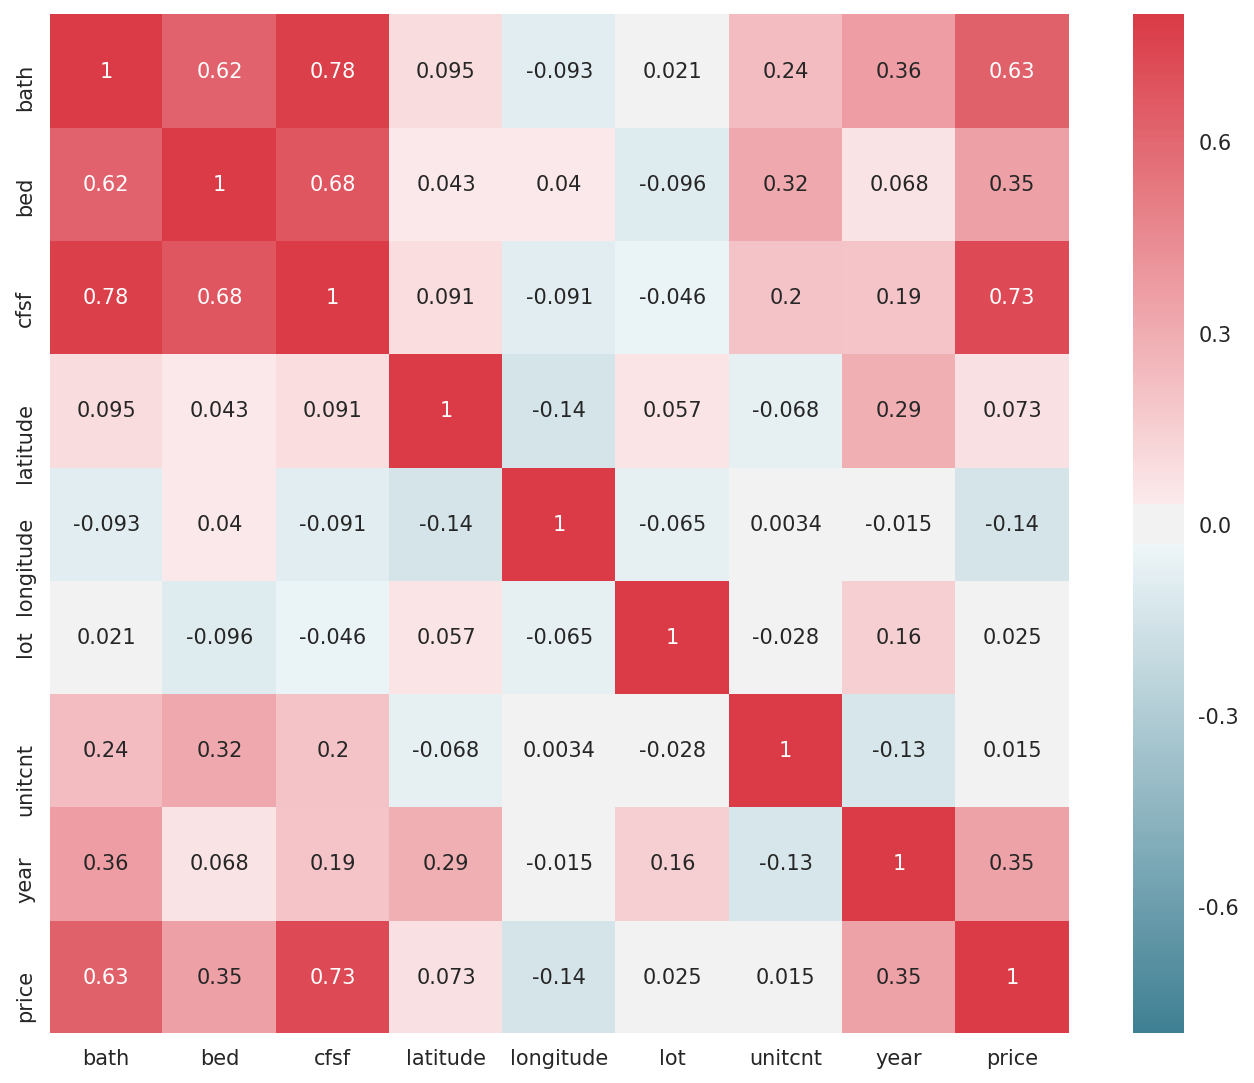

In [33]:
# 아웃라이어를 제거한 데이터
df2 = df1.drop(idx)
corrmatrix(df2)

아웃라이어를 제거한 데이터를 확인해 보면, 제거하기 전에 비해 종속변수와 독립변수간의 상관관계가 높아졌음을 알 수 있다.

In [34]:
# 인덱스정렬
a = np.arange(len(df2))
df2 = df2.set_index(a)

In [35]:
df2.tail()

,aircondition,bath,bed,qualitytype,cfsf,spa,heating,latitude,longitude,lot,pool,landuse,city,unitcnt,year,price
1782749,0.0,2.0,2.0,7.0,1436.0,0,0.0,33989498.0,-118276254.0,4840.0,0.0,246.0,12447.0,2.0,1913.0,93673.0
1782750,0.0,2.0,2.0,7.0,1270.0,0,7.0,33966259.0,-118297173.0,4079.0,0.0,261.0,12447.0,1.0,1936.0,62683.0
1782751,0.0,2.0,4.0,7.0,1484.0,0,2.0,34123566.0,-117826007.0,8492.0,0.0,261.0,11626.0,1.0,1955.0,55094.0
1782752,1.0,3.0,5.0,4.0,2862.0,0,2.0,34095425.0,-117740858.0,4499.0,0.0,269.0,20008.0,1.0,2012.0,304646.0
1782753,0.0,2.0,4.0,4.0,2360.0,0,20.0,34689046.0,-118066841.0,7531.0,0.0,261.0,5534.0,1.0,2013.0,201752.0


아웃라이어를 제거한 데이터로 회귀분석을 해 보았다.

In [36]:
model3 = sm.OLS.from_formula('price ~ I(bath + bed + cfsf) +C(qualitytype) + latitude +  longitude + C(spa) + C(heating) + C(pool) + C(landuse)', df2)
result3 = model3.fit()
print(result3.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                 1.731e+05
Date:                Wed, 12 Jul 2017   Prob (F-statistic):               0.00
Time:                        16:03:54   Log-Likelihood:            -2.2217e+07
No. Observations:             1782754   AIC:                         4.443e+07
Df Residuals:                 1782730   BIC:                         4.443e+07
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -1.83

Adj. R-squared값을 확인해 보면 기존의 0.604에서 0.696으로 0.092이 증가 했음을 알 수 있다.

## PCA

회귀분석 결과 다중공선성이 있는 것으로 보이므로 PCA를 이용한 차원축소를 통해 다중공선성과 과최적화를 줄이고자 한다.

In [264]:
#독립변수들 표준화 
from sklearn.preprocessing import StandardScaler
def std(data):
    numeric_columns = ["bath", "bed", "cfsf", "year", "latitude", "longitude"]
    stdData = StandardScaler().fit_transform(data[numeric_columns])
    stdData = pd.DataFrame(stdData, columns=numeric_columns)
    return stdData

PCA를 위해 연속형 변수를 표준화 하였다

In [265]:
from sklearn.decomposition import PCA as sklearnPCA
def pca(data, n):
    col = [ "PC" + str(x+1) for x in range(n)]
    tempPCA = sklearnPCA(n_components=n)
    newIndex = tempPCA.fit_transform(data)
    newData = pd.DataFrame(newIndex)
    newData.columns = col
    return newData, tempPCA

In [266]:
stdData = std(df2)
pcaData, PCA = pca(stdData,3)
pcaData.head()

,PC1,PC2,PC3
0,2.606742,-2.004338,-1.193328
1,2.895912,0.948390,0.525914
2,-0.577621,-1.485727,-0.251893
3,-0.222877,0.551244,1.733760
4,0.390403,0.523489,0.272646


In [269]:
pd.DataFrame(PCA.components_.T)

,0,1,2
0,0.574938,0.044155,-0.000532
1,0.504127,0.300698,0.028256
2,0.567474,0.147967,0.104068
3,0.260830,-0.525192,-0.468580
4,0.141449,-0.678943,-0.097685
5,-0.072350,0.385937,-0.871356


In [98]:
# 인덱스정렬
a = np.arange(len(df2))
df2 = df2.set_index(a)

In [99]:
pcaData["qualitytype"] = df2["qualitytype"]
pcaData["spa"] = df2["spa"]
pcaData["heating"] = df2["heating"]
pcaData["pool"] = df2["pool"]
pcaData["landuse"] = df2["landuse"]
pcaData["price"] =df2["price"]

In [100]:
pcaData.head()

,PC1,PC2,PC3,qualitytype,spa,heating,pool,landuse,price
0,2.606742,-2.004338,-1.193328,4.0,0,2.0,0.0,261.0,218982.0
1,2.895912,0.948390,0.525914,4.0,0,0.0,0.0,246.0,267623.0
2,-0.577621,-1.485727,-0.251893,4.0,0,2.0,0.0,266.0,229399.0
3,-0.222877,0.551244,1.733760,4.0,0,2.0,0.0,261.0,207035.0
4,0.390403,0.523489,0.272646,7.0,0,0.0,0.0,246.0,122915.0


In [155]:
model3 = sm.OLS.from_formula("price ~ PC1 + PC2 + PC3 + C(heating) +C(pool) + C(spa) ", data=pcaData).fit()
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.498
Model:                            OLS   Adj. R-squared:                  0.498
Method:                 Least Squares   F-statistic:                 2.207e+05
Date:                Wed, 12 Jul 2017   Prob (F-statistic):               0.00
Time:                        12:19:57   Log-Likelihood:            -2.2649e+07
No. Observations:             1782754   AIC:                         4.530e+07
Df Residuals:                 1782745   BIC:                         4.530e+07
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            7.82e+04    213

연속변수만 차원축소를 한 결과 성능은 조금 떨어지지만 Condition number가 크게 개선되었다.

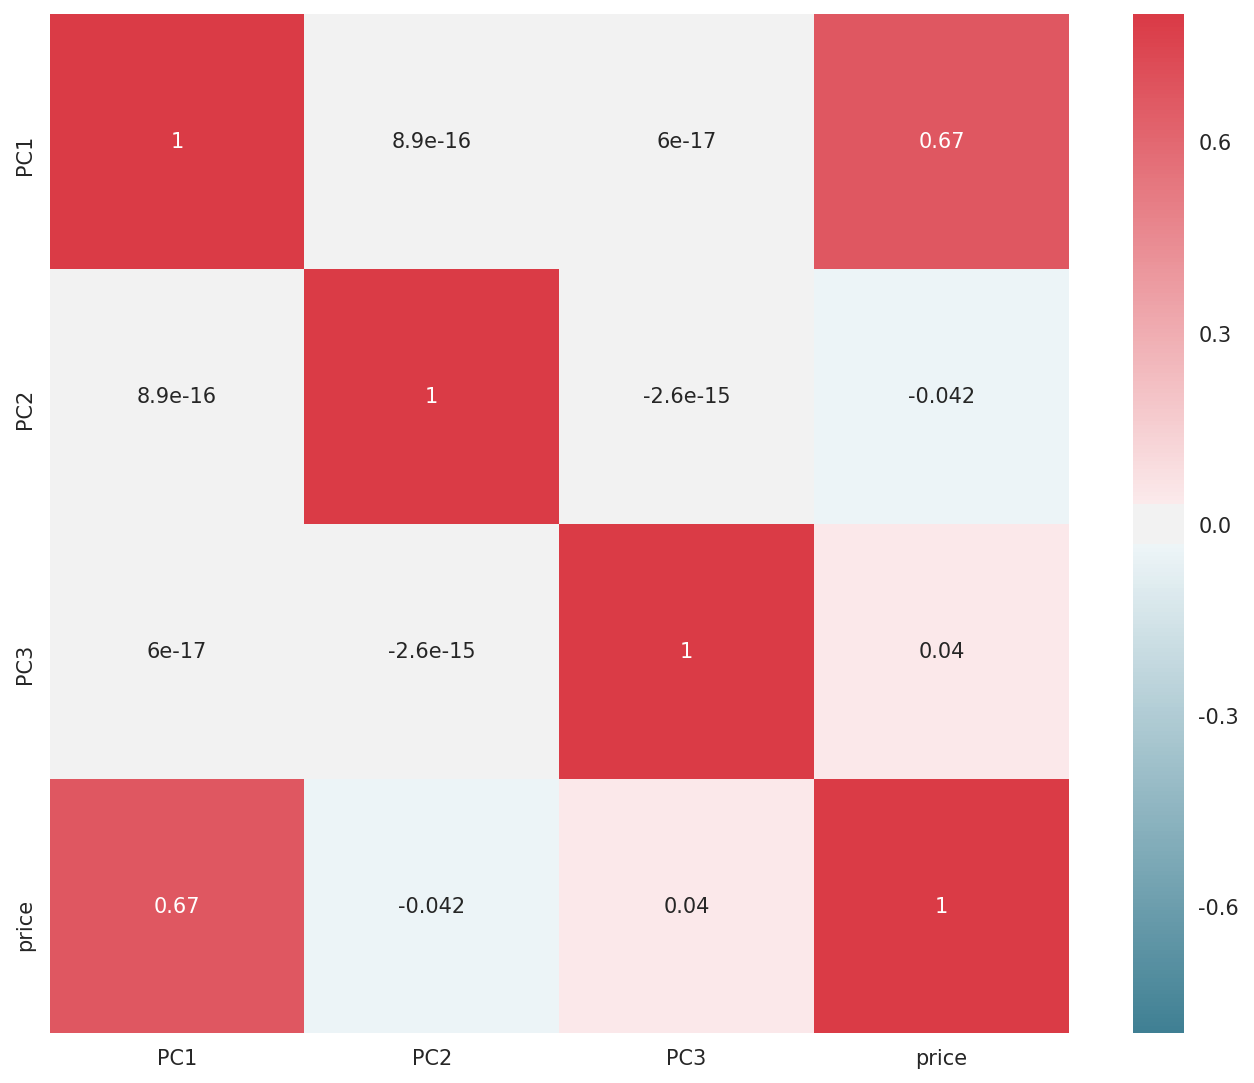

In [109]:
corrmatrix(pcaData)

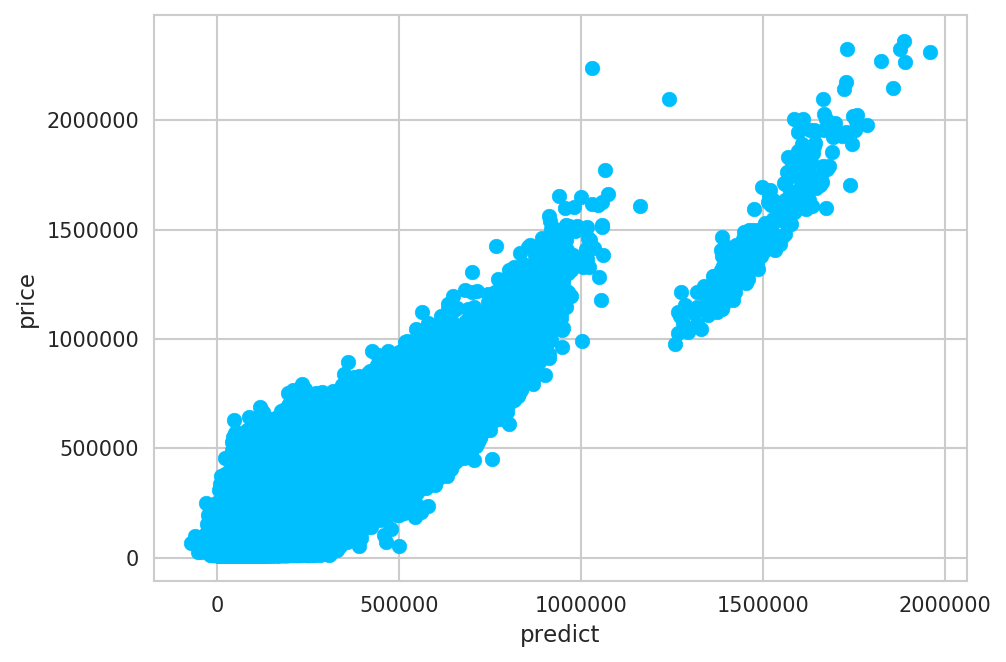

In [148]:
plt.figure(figsize=(7, 5), dpi=150)
plt.scatter(model3.predict(), pcaData['price'], color="deepskyblue")
plt.xticks(np.arange(0,2500000,500000))
plt.xlabel("predict")
plt.ylabel("price")
plt.show()

## 더미변수도 같이 PCA

In [111]:
qual_dummy = pd.get_dummies(df2["qualitytype"], prefix="qual")
heating_dummy = pd.get_dummies(df2["heating"], prefix="heat")
pool_dummy = pd.get_dummies(df2["pool"], prefix="pool")
spa_dummy = pd.get_dummies(df2["spa"], prefix="spa")

In [136]:
X = pd.concat([df2[["bath", "bed", "cfsf", "year", "latitude", "longitude"]], qual_dummy, heating_dummy, pool_dummy, spa_dummy], axis=1)
y = df2["price"]

In [137]:
#독립변수들 표준화 
from sklearn.preprocessing import StandardScaler
def std(data):
    stdData = StandardScaler().fit_transform(data)
    stdData = pd.DataFrame(stdData)
    return stdData

In [138]:
pca_X, pca_ele = (pca(std(X), 10))

In [139]:
pc = pd.concat([y, pca_X], axis=1)

In [140]:
pc.head()

,price,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,218982.0,3.088158,0.379684,0.300293,-1.804260,-0.126803,-0.748622,0.807174,0.000911,-0.018914,0.268307
1,267623.0,1.827798,3.695848,-0.278191,-0.253889,-0.862211,-0.631707,-0.080766,0.028293,0.024636,-0.079338
2,229399.0,1.419607,-1.596494,0.579916,-1.777973,0.351501,-0.109470,0.068978,-0.020734,0.011288,-0.014036
3,207035.0,0.947079,-0.151904,0.204729,-0.785894,0.062105,-0.578131,0.281702,-0.003659,0.021657,0.089471
4,122915.0,-1.079163,2.620986,-0.372085,0.266775,-0.789360,-0.955387,-0.389486,-0.111913,0.005839,0.004366


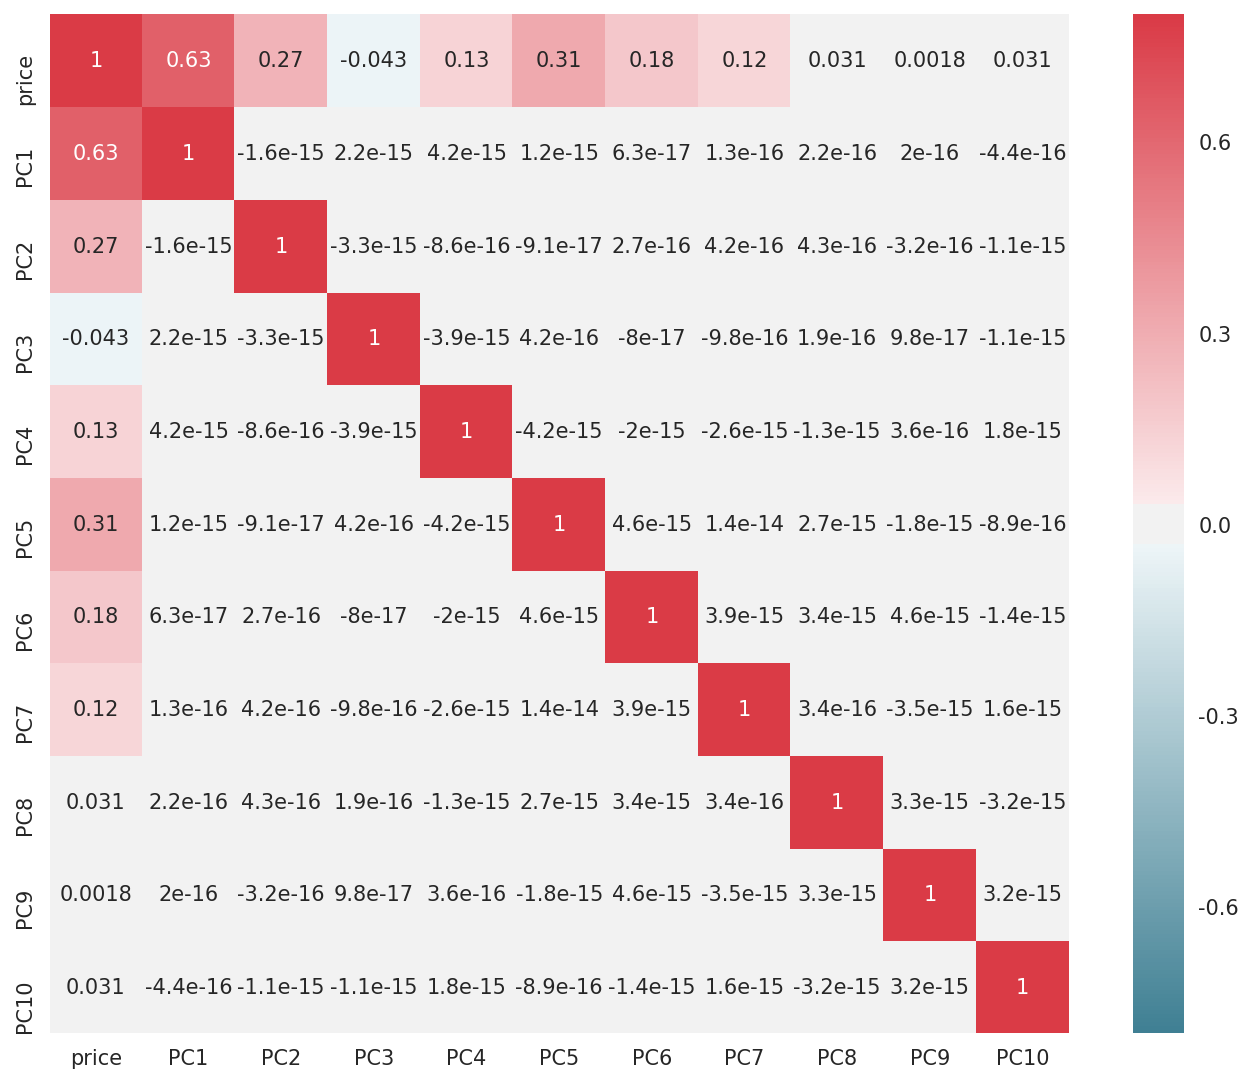

In [141]:
corrmatrix(pc)

In [145]:
model4 = sm.OLS.from_formula("price ~ PC1 + PC2 + PC4 + PC5 + PC6 + PC7", data=pc).fit()
print(model4.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                 5.285e+05
Date:                Wed, 12 Jul 2017   Prob (F-statistic):               0.00
Time:                        11:14:12   Log-Likelihood:            -2.2352e+07
No. Observations:             1782754   AIC:                         4.470e+07
Df Residuals:                 1782747   BIC:                         4.470e+07
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.437e+05     50.498   2846.005      0.0

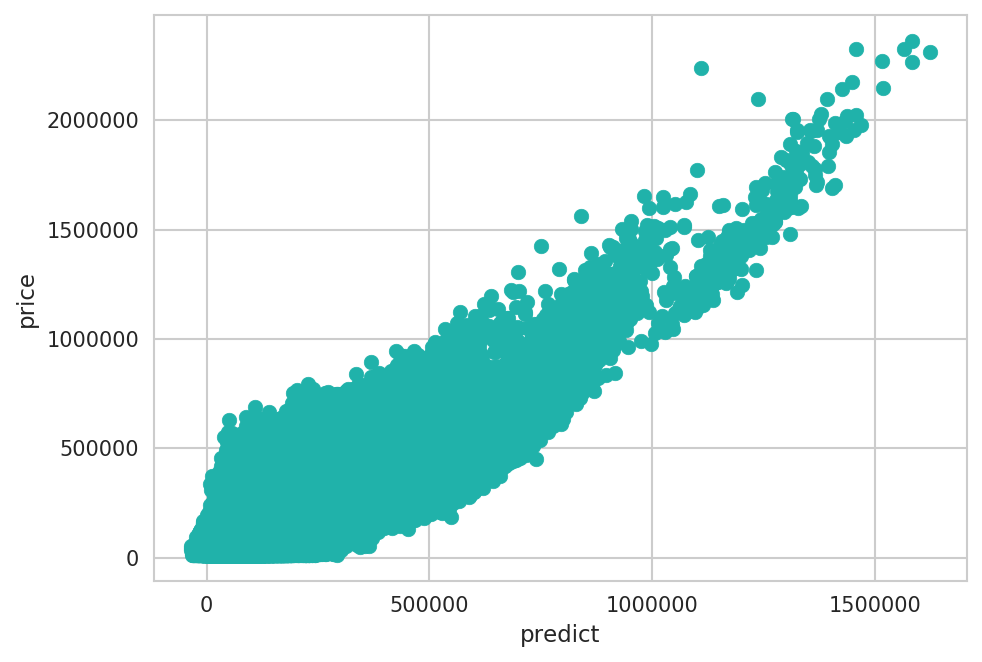

In [146]:
plt.figure(figsize=(7, 5), dpi=150)
plt.scatter(model4.predict(), pcaData['price'], color="lightseagreen")
plt.xticks(np.arange(0,2000000,500000))
plt.xlabel("predict")
plt.ylabel("price")
plt.show()

## 교차검증 

일반적으로 테스트 데이터가 별도로 존재하는 경우가 많지 않기 때문에 보통은 원래 트레이닝용으로 확보한 데이터 중 일부를 떼어내어 테스트 데이터로 사용하는 경우가 많다. 그런데 트레이닝이나 테스트 데이터를 어떻게 골라내느냐에 따라 모형의 성능이 조금씩 달라질 수 있으므로 한 세트의 트레이닝/테스트 데이터만 사용하는 것이 아니라 여러가지 서로 다른 트레니인/테스트 데이터를 사용하여 복수의 테스트를 실시한 후 이 성능 자료로 부터 **평균 성능(mean performance)과 성능 분산(performance variance)**를 모두 구하는 것이 좋다.

이러한 테스트 방법을 **교차 검증(cross validation)**이라고 한다.

In [64]:
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [65]:
X = pca_X[[ "PC1", "PC2", "PC3","PC5", "PC6", "PC7", "PC8", "PC10"]]

In [66]:
mod = LinearRegression()
cv = KFold(30)
cv_score = cross_val_score(mod, X, y, scoring="r2", cv=cv)
cv_score

/Users/sinsanghun/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


array([ 0.63901907,  0.62810236,  0.63483431,  0.62025707,  0.63076443,
        0.62602106,  0.62025439,  0.63471371,  0.6277628 ,  0.63450827,
        0.62993579,  0.62574024,  0.63448942,  0.62515495,  0.63245849,
        0.61820802,  0.62627504,  0.64951748,  0.6463497 ,  0.62129577,
        0.63011724,  0.63681664,  0.62329678,  0.62488283,  0.62777391,
        0.62858431,  0.63909359,  0.62974618,  0.64052191,  0.62382398,
        0.64914811,  0.63732446,  0.63049286,  0.63394197,  0.62884766,
        0.6256158 ,  0.61657056,  0.62997096,  0.62277568,  0.62479478,
        0.64055525,  0.63571257,  0.63276248,  0.63386812,  0.63890251,
        0.62950829,  0.63003992,  0.62648121,  0.63426322,  0.6305257 ])

In [67]:
print("평균 성능:", cv_score.mean())
print("성능 분산 :", cv_score.var())

평균 성능: 0.630848437048
성능 분산 : 5.24070799047e-05


In [ ]:
params_dist_grid = {
    'max_depth': randint(6,11),
    'gamma': np.linspace(0, 1, 3),
    'subsample': np.linspace(0.1, 1, 3),
    'n_estimators': randint(50,165),
    'learning_rate': np.linspace(0, 1, 6),
    'reg_lambda': np.linspace(0.1,1e2,20)
}

params_fixed = {
    'objective': 'reg:linear',
    'silent': 1,
    'nthread': 6
}

rs_grid = RandomizedSearchCV(
    estimator=XGBRegressor(**params_fixed),
    param_distributions=params_dist_grid,
    n_iter=15,
    cv=10,
    scoring='r2'
)

rs_grid.fit(x_train, np.log(y_train))

params = rs_grid.best_params_

bst = XGBRegressor(**params).fit(X, y)
preds = bst.predict(X)
print("======================================================================================")
print("                            Summary Report (Test Data Set)                            ")
print("======================================================================================")
print("R2_Score: ", r2_score(y, preds))
print("MSE     : ", mean_squared_error(np.log(y_test), preds))

plt.figure(figsize=(15,10))
plt.scatter(y, preds)
plt.show()

KFold 클래스를 이용해 교차검증을 한 결과 50개의 sub-set에서 성능이 고르게 나타남을 알 수 있다.